# GRNN2
Author: Joshua Ryu
Date: 04/19/2021

Update summary:
- Following Kim & Sejnowski 2021 closer: transfer function, time constants
- Generalized gating to input/recurrent/output gating.
- Added delay rule

# Prep training and testing

In [1]:
import copy, os, sys, time

import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

sys.path.append('../')
from det_rnn import *
import det_rnn.train as utils_train
import det_rnn.analysis as utils_analysis
from det_rnn.train.model import Model
from models.gatedRNN.gatedRNN import gRNN, RNNCell
from models.gatedRNN.gatedRNN_hyper import grnn_hp

from models.base.analysis import behavior_summary, estimation_decision

from utils.plotfnc import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  0


In [2]:
print('batchsize = ' + str(par['batch_size']))
par

batchsize = 128


{'design': {'iti': (0, 1.5),
  'stim': (1.5, 3.0),
  'delay': ((3.0, 4.0), (5.5, 6.0)),
  'decision': (4.0, 5.5),
  'estim': (6.0, 7.5)},
 'dm_output_range': 'design',
 'em_output_range': 'design',
 'dead': 'design',
 'mask_dm': {'iti': 1.0,
  'stim': 1.0,
  'decision': 1600.0,
  'delay': 1.0,
  'estim': 1.0,
  'rule_iti': 2.0,
  'rule_stim': 2.0,
  'rule_decision': 3200.0,
  'rule_delay': 2.0,
  'rule_estim': 2.0},
 'mask_em': {'iti': 1.0,
  'stim': 1.0,
  'decision': 1.0,
  'delay': 1.0,
  'estim': 200.0,
  'rule_iti': 2.0,
  'rule_stim': 2.0,
  'rule_decision': 2.0,
  'rule_delay': 2.0,
  'rule_estim': 400.0},
 'input_rule': 'design',
 'output_dm_rule': 'design',
 'output_em_rule': 'design',
 'input_rule_strength': 1,
 'output_dm_rule_strength': 1,
 'output_em_rule_strength': 1,
 'reference': [-4, -3, -2, -1, 1, 2, 3, 4],
 'strength_ref': 1.0,
 'type': 'orientation',
 'stim_dist': 'uniform',
 'natural_a': 0.0002,
 'ref_dist': 'uniform',
 'trial_per_subblock': 1,
 'stim_encoding': 's

In [3]:
# training set
par_train = copy.deepcopy(par)
par_train['batch_size'] = 50 # smaller batch size
par_train['n_ori'] = 24
par_train = update_parameters(par_train)
stim_train = Stimulus(par_train)

# generate training data
train_data = stim_train.generate_trial()

orientation = 30.0, reference = 52.5


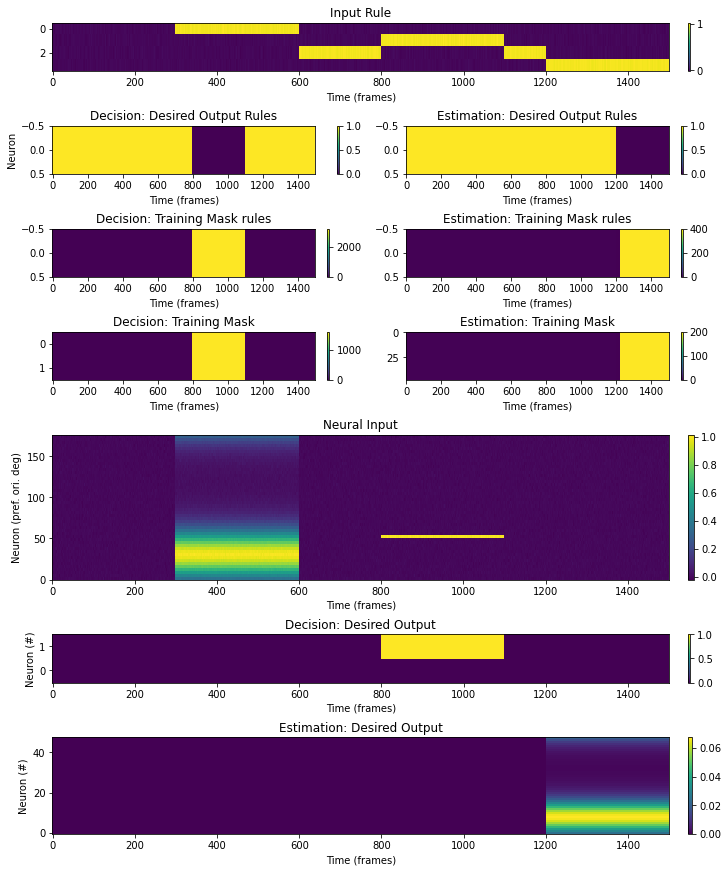

In [4]:
# check stimulus
random_trial_num = np.random.randint(stim_train.batch_size)
# random_trial_num = 2
target_ori = np.arange(0,180,180/par_train['n_ori'])[train_data['stimulus_ori'][random_trial_num]]
ref_ori = np.arange(0,180,180/par_train['n_tuned_input'])[train_data['ref_neuron'][random_trial_num]]
print('orientation = ' + str(target_ori) + ', reference = ' + str(ref_ori))
plot_trial(train_data, stim_train, TEST_TRIAL=random_trial_num)

In [5]:
# set up a new test set with more batch
par_test                        = copy.deepcopy(par)
par_test['n_ori']               = 24
par_test['batch_size']          = 1000 # at least 9 refs * 24 orientations
par_test['reference']           = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
par_test                        = update_parameters(par_test)
stim_test                       = Stimulus(par_test)
test_data                       = stim_test.generate_trial()

# set up network and train


In [6]:
grnn_hp = grnn_hp(par_train)
grnn    = gRNN(grnn_hp)

model output path = /Users/JRyu/github/det_rnn/experiments/grnn2/hptest001
(gRNN) Building rnn...
(gRNN) Building rnncell...
(gRNN) Network initialization complete


In [7]:
grnn.hp

{'output_base': '/Users/JRyu/github/det_rnn/experiments/grnn2/hptest',
 'model_number': 1,
 'saving_freq': 50,
 'dtype': 'tf.float32',
 'loss_mse_dec': 0.0001,
 'loss_mse_est': 0.0001,
 'loss_ce_dec': 10,
 'loss_ce_est': 0.1,
 'loss_spike': 0.0001,
 'loss_L1': 0.0001,
 'loss_L2': 0,
 'dropout': 0,
 'nsteps_train': 5000,
 'learning_rate': 0.005,
 'clip_max_grad_val': 10,
 'scheduler': None,
 'dt': 10.0,
 'tau_train': True,
 'tau_min': 10,
 'tau_max': 15000,
 'noise_sd': 0.5,
 'dale': False,
 'stsp': False,
 'exc_inh_prop': 0.8,
 'alpha_std': (0.05, 0.00667),
 'alpha_stf': (0.00667, 0.05),
 'U': (0.15, 0.45),
 'n_input': 52,
 'n_tuned_input': 48,
 'n_hidden': 300,
 'n_tuned_output': 48,
 'n_output_dm': 3,
 'n_rule_input': 4,
 'n_rule_output_dm': 1,
 'n_rule_output_em': 1,
 'act': 'sigmoid',
 'gate_out': False,
 'gate_rnn': True,
 'rnn_weights_shift': 86,
 'rnn_weights_scale': 112,
 'rnn_noise_type': 'Normal_fixed',
 'input_rule_rg': {'stimulus': array([300, 301, 302, 303, 304, 305, 306, 

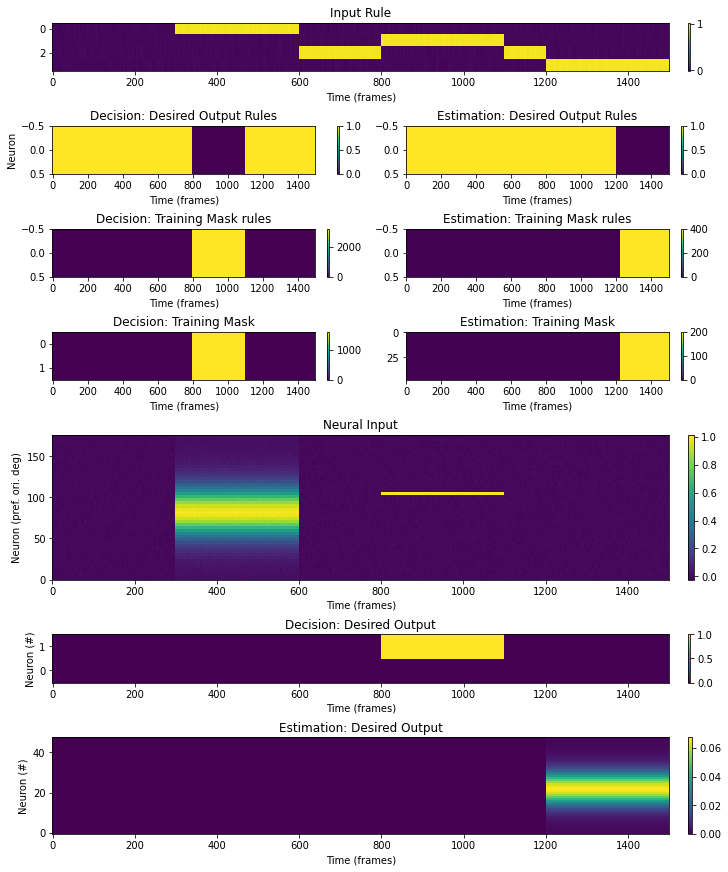

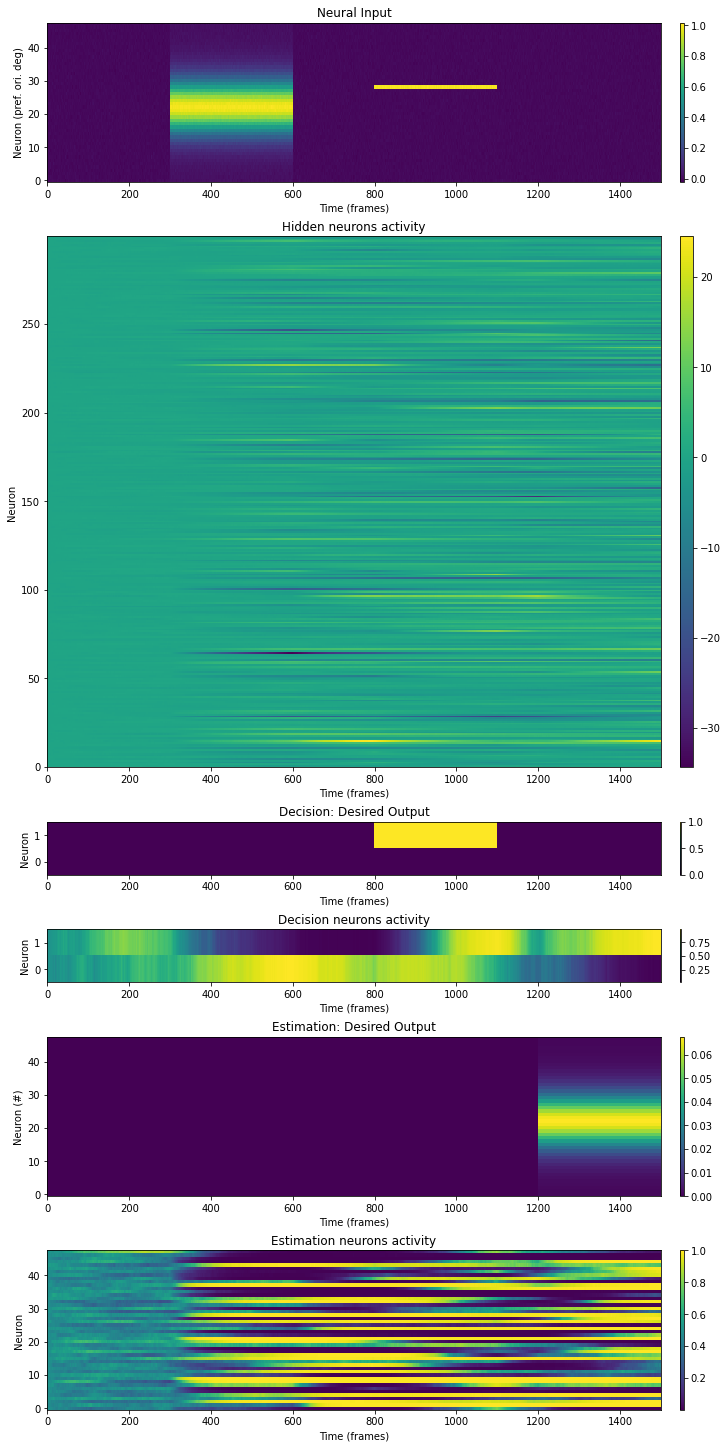

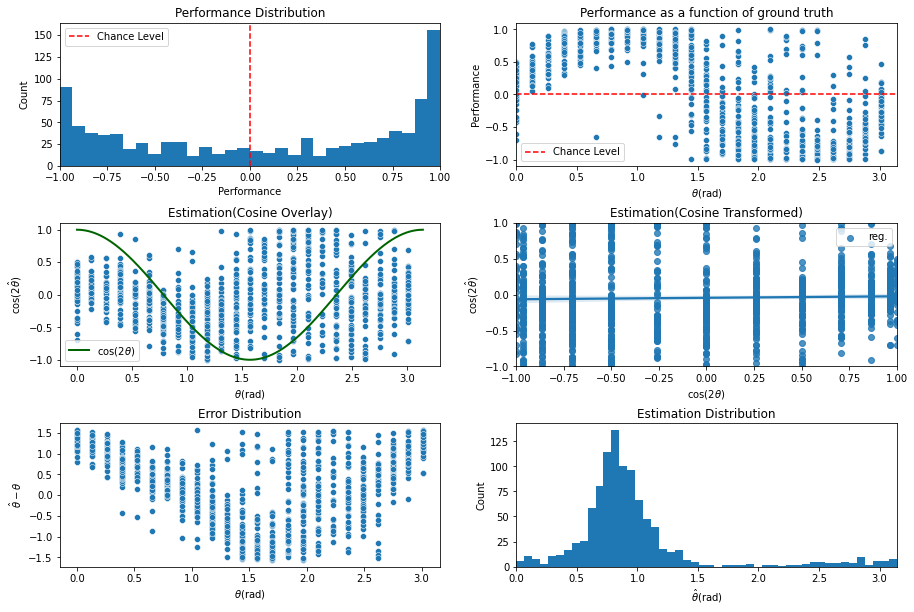

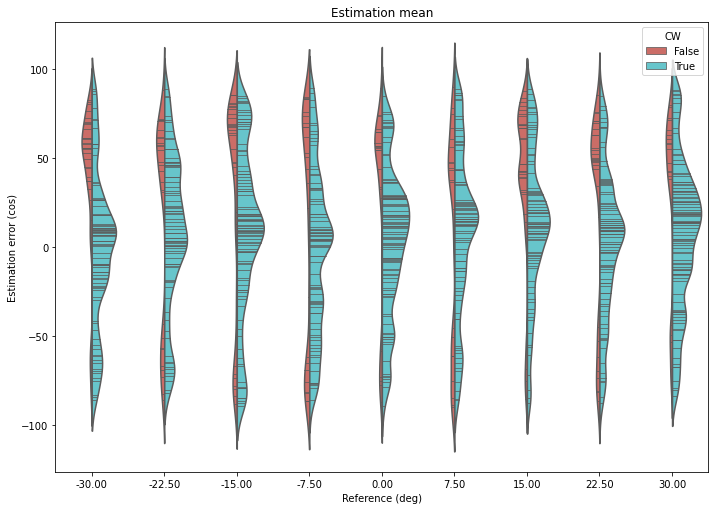

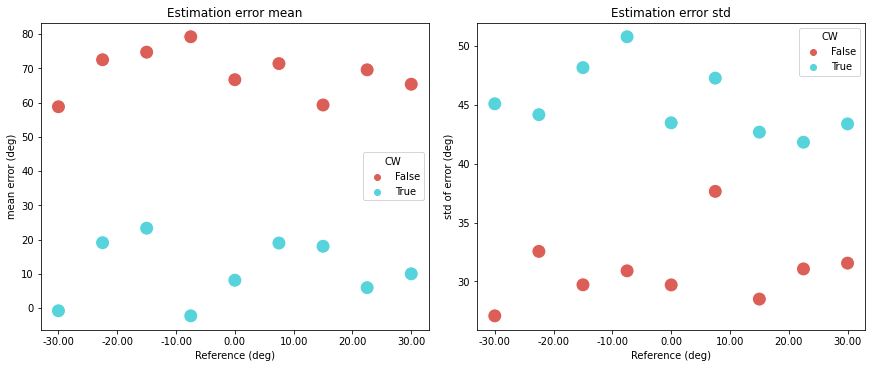

/opt/anaconda3/envs/detrnn37/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


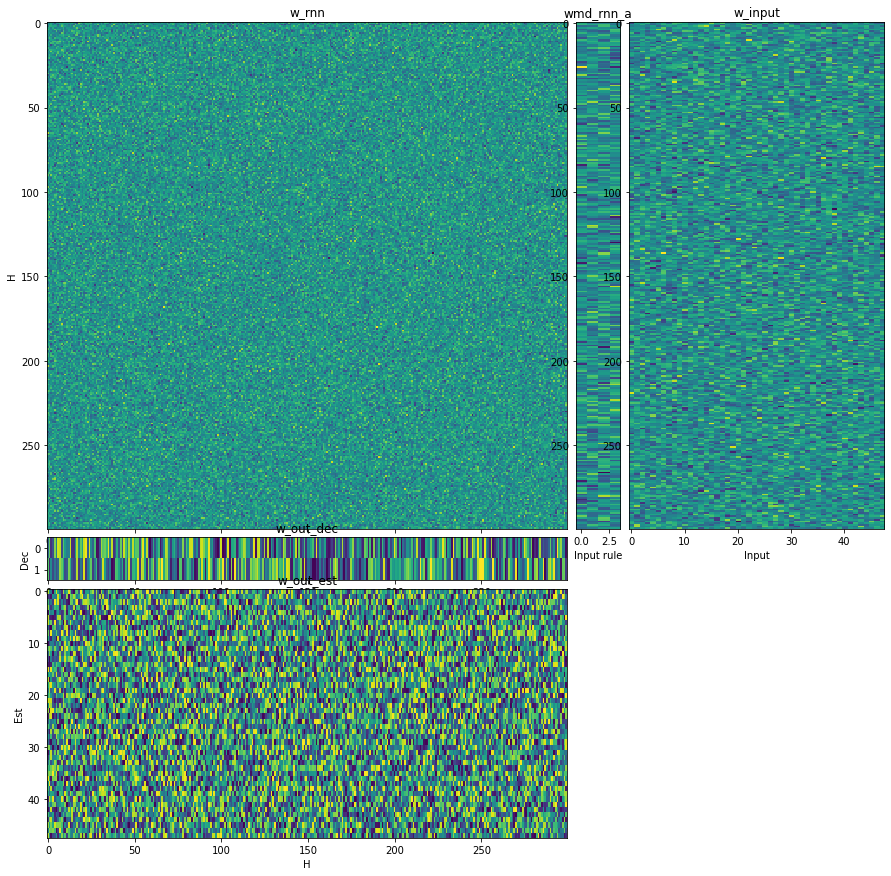

In [8]:
# evaluate and visualize before training
test_lossStruct, test_outputs  = grnn.evaluate(test_data)

# plot rnn trial and outputs
TEST_TRIAL = np.random.randint(stim_test.batch_size) 
plot_trial(test_data, stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)
plot_rnn_output(test_data,test_outputs,stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)

# estimation summary
est_summary, dec_summary = behavior_summary(test_data, test_outputs, stim_test)
behavior_figure(est_summary)

# plot rnn decision effects on estimation
df_trials, df_sum = estimation_decision(test_data, test_outputs, stim_test)
plot_decision_effects(df_trials,df_sum)

# visualize weights
grnn.visualize_weights()

In [ ]:
# train network
grnn.train(stim_train = stim_train, stim_test= stim_train, niter=100)

   1/1000 [..............................] - ETA: 8265s - Train Loss: 8.7397 - Test Loss: 13.3109 - Test est cos(error): 0.6801 - Test dec perf: 0.3800 - Grads: 65.4834


 Epoch 2, Train Loss: 8.739678382873535, Test Loss: 13.310873985290527


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


From /opt/anaconda3/envs/detrnn37/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn2/hptest001/model/iter1/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn2/hptest001/model/iter1/assets


  51/1000 [>.............................] - ETA: 8582s - Train Loss: 7.3108 - Test Loss: 7.3108 - Test est cos(error): 0.9546 - Test dec perf: 0.6200 - Grads: 0.0325


 Epoch 52, Train Loss: 7.310836315155029, Test Loss: 7.310766696929932


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn2/hptest001/model/iter51/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn2/hptest001/model/iter51/assets


 101/1000 [==>...........................] - ETA: 8548s - Train Loss: 7.3025 - Test Loss: 7.3029 - Test est cos(error): 0.9681 - Test dec perf: 0.6200 - Grads: 0.0398


 Epoch 102, Train Loss: 7.3024702072143555, Test Loss: 7.302914142608643


INFO:tensorflow:Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn2/hptest001/model/iter101/assets


Assets written to: /Users/JRyu/github/det_rnn/experiments/grnn2/hptest001/model/iter101/assets


 105/1000 [==>...........................] - ETA: 8592s - Train Loss: 7.3017 - Test Loss: 7.3010 - Test est cos(error): 0.9534 - Test dec perf: 0.6200 - Grads: 0.0406

In [1]:
test_outputs['est_output'][-5, 3,:]

NameError: name 'test_outputs' is not defined

In [ ]:
# evaluate and visualize after training
test_lossStruct, test_outputs   = grnn.evaluate(test_data)

# plot rnn trial and outputs
plot_trial(test_data, stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)
plot_rnn_output(test_data,test_outputs,stim_train, TEST_TRIAL=TEST_TRIAL, savename=None)

# estimation summary
est_summary, dec_summary = behavior_summary(test_data, test_outputs, stim_train)
behavior_figure(est_summary)

# plot rnn decision effects on estimation
df_trials, df_sum = estimation_decision(test_data, test_outputs, stim_test)
plot_decision_effects(df_trials,df_sum)

# load trained model and parameters

In [ ]:
import os
import tensorflow as tf
import yaml

basedir = '/Users/JRyu/github/det_rnn/experiments/grnn2/test005/'
model = tf.saved_model.load(os.path.join(basedir, 'model', 'iter51'))

with open(os.path.join(basedir, 'hp.yaml'),'rb') as file:
    hp = yaml.load(file, Loader=yaml.Loader)

hp